Simulating the Quantum PageRank alorithm proposed in https://arxiv.org/abs/1112.2079

In [302]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
ALPHA = 0.85

In [283]:
example_net = np.array([[0, 0, 1, 0, 0, 0, 0], [1, 0, 1, 0, 0, 0, 0], [0, 0, 0, 1, 0, 1, 0], [
                       0, 0, 0, 0, 0, 0, 0], [1, 0, 0, 1, 0, 0, 1], [1, 0, 0, 1, 0, 0, 0], [1, 0, 1, 0, 1, 0, 0]]).astype(float)

In [284]:
def connectivity_from_adj(adj):
    # construct the modified hyperlink matrix E from the adjacency matrix
    d = len(adj)
    connec = np.zeros((d, d))

    for i in range(len(connec)):
        # count the links leaving a node and add values to E accordingly
        count = 0
        edges = []
        for j in range(d):
            if adj[j, i] == 1:
                count += 1
                edges.append(j)

        if count > 0:
            new_value = 1/count
            for edge in edges:
                connec[edge, i] = new_value
        else:
            # no links
            for n in range(d):
                connec[n, i] = 1/d

    return connec

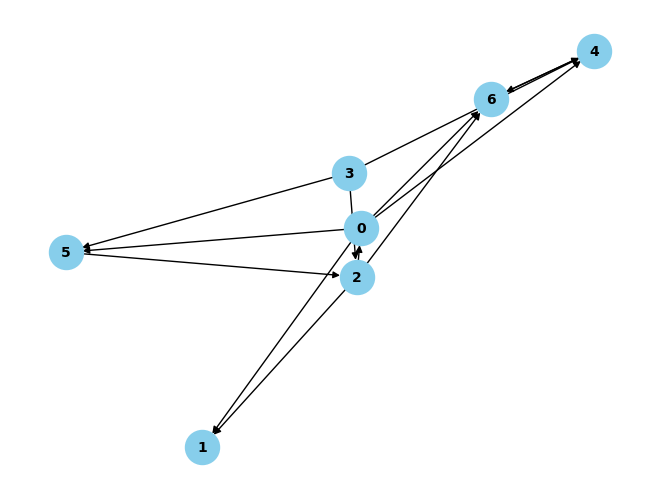

In [285]:
G = nx.from_numpy_array(example_net.T, create_using=nx.DiGraph)

# draw the network
nx.draw(G, with_labels=True, node_color='skyblue',
        node_size=600, font_size=10, font_weight='bold')


plt.show()

In [286]:
def google_from_connectivity(connectivity):
    # construct the Google matrix from the E matrix
    goog = connectivity * ALPHA
    n = len(connectivity)
    ones = np.ones((n, n))
    goog += ones*(1-ALPHA)/n
    return goog

In [287]:
def states_from_google(google):
    #construct the states for nodes, the superpositions of links leaving the node
    #store the statevectors in the columns of a matrix
    n = len(google)
    states = np.zeros((n**2, n))
    for node in range(n):
        
        first = np.zeros(n)#basis vector of the starting node
        first[node] = 1
        statevec = np.zeros(n**2)
        for basevec in range(n):
            second = np.zeros(n)#basis vector of the second node
            second[basevec] = 1
            #kronecker product of the basisvectors weighted by the value in the googlematrix
            statevec += np.sqrt(google[basevec, node])*np.kron(first, second)
        states[:, node] = statevec
    return states

In [288]:
def swap_op(dim):
    #defining the swap operator with the given dimensions
    swap = np.zeros((dim**2, dim**2))
    for first_base in range(dim):
        first = np.zeros(dim)
        first[first_base] = 1
        for second_base in range(dim):
            second = np.zeros(dim)
            second[second_base] = 1
            
            swap += np.outer(np.kron(first, second), np.kron(second, first))
    return swap

In [290]:
def init_state(state_matrix):
    # define the starting vector of the random walk
    init_state = np.zeros(state_matrix.shape[0])
    for node in range(state_matrix.shape[1]):
        init_state += state_matrix[:, node]

    return init_state/np.sqrt(state_matrix.shape[1])

In [291]:
def a_op(state_matrix):
    #parameter is a matrix of the state vectors
    #A operator for projecting from the space of nodes to the space edges
    n = state_matrix.shape[1]
    a_op = np.zeros((n**2, n))
    for node in range(n):
        first = state_matrix[:, node]#get the state vector from the matrix, first vector in the product

        second = np.zeros(n)#basis vector, second vector in the product
        second[node] = 1
        add = np.outer(first, second)

        a_op += add
    return a_op

In [292]:
def d(google):
    #D matrix from the google matrix
    n = len(google)
    d = np.zeros((n, n))
    for i in range(n):
        for j in range(n):
            d[i, j] = np.sqrt(google[i, j] * google[j, i])
    return d

In [293]:
def eigenv_in_dyn(google, state_matrix):
    #function returns the eigenvectors and eigenvalues of the U operator in the dynamical subspace 
    eig_values, vectors = np.linalg.eig(d(google))#solve problem for D
    #the vectors are stored as columns of an array
    expanded = []
    a = a_op(state_matrix)
    s = swap_op(len(google))
    eigenvals_of_u = []
    for val in eig_values:
        #eigenvalues of U from the ones of D
        eigenvals_of_u.append(np.exp(1j*np.arccos(val)))
        eigenvals_of_u.append(np.exp(-1j*np.arccos(val)))

    for j in range(vectors.shape[1]):
        #project the eigenvectors of D to the space of edges 
        expanded.append(np.inner(a, vectors[:, j]))
    eigenvec_in_dyn = []

    i = 0
    for exp_vector in expanded:
        #calculate the eigenvectors of U
        eigenvec_in_dyn.append(exp_vector-eigenvals_of_u[i]*np.inner(s, exp_vector))
        eigenvec_in_dyn.append(
            exp_vector-eigenvals_of_u[i+1]*np.inner(s, exp_vector))
        i += 2

    return eigenvec_in_dyn, eigenvals_of_u

In [294]:
def instantaneous(google, state_matrix, node, time):
    #calculate the instantaneous QPR
    eigenvecs, eigenvals = eigenv_in_dyn(google, state_matrix)
    init = init_state(state_matrix)

    bas = node#number of the basis vector of the node in question
    sum = 0

    for i, e_vec in enumerate(eigenvecs):
        res = []
        for n in range(len(google)):
            #the partial inner product
            res.append(e_vec[bas + n*len(google)])

        res = np.array(res)
        
        sum += eigenvals[i]**(2*time)*res * np.inner(np.conjugate(e_vec), init)+0j#calculate the remaining 

    return np.sqrt(np.inner(np.conjugate(sum), sum))**2 #taking the norm

In [295]:
def avg_imp(google, state_matrix, node, max_time):
    #average score of a node in a given time
    importances = []
    for t in range(max_time):
        importances.append(instantaneous(google, state_matrix, node, t))
    return np.mean(importances)

In [301]:
#test the algorithm on the example network defined in the beginning
g = google_from_connectivity(connectivity_from_adj(example_net))
states = states_from_google(g)
for j in range(7):
    print(j, avg_imp(g, states, j, 20))

0 (0.15070432614652776+0j)
1 (0.1833274725158147+0j)
2 (0.23378711380657624+0j)
3 (0.2683934652007226+0j)
4 (0.07832269670460318+0j)
5 (0.13639818065527634+0j)
6 (0.15260080587380884+0j)
